In [8]:
import sys
CODE_DIR = "/home/cbarkhof/fall-2021" # <-- change the path to your code directory
sys.path.append("../bda_models")
sys.path.append(CODE_DIR)

In [9]:
import os
import torch
import pickle
import pandas as pd
import numpy as np
from tabulate import tabulate

%config InlineBackend.figure_format='retina'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import seaborn as sns; sns.set()
import torch.distributions as td

from analysis.bda_models.bda_dp_mixture_surprisal_vals import *

In [10]:
SAVE_DIR = "output_files"
os.makedirs(SAVE_DIR, exist_ok=True)

# PTB - Topics
TOPIC_MODEL_SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/topic_model_surprisal_values.pt"
TOPIC_MODEL_SAVE_SURPRISAL_DP_FILE = f"{SAVE_DIR}/topic_model_surprisal_dp_mixtures.pt"

# PTB - Sequence length
SEQUENCE_LEN_SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/sequence_len_surprisal_values.pt"
SEQUENCE_LEN_SAVE_SURPRISAL_DP_FILE = f"{SAVE_DIR}/sequence_length_surprisal_dp_mixtures.pt"

# MNIST
MNIST_SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/MNIST_surprisal_values.pt"
MNIST_SAVE_SURPRISAL_DP_FILE = f"{SAVE_DIR}/MNIST_surprisal_dp_mixtures.pt"

# Fetch the experiments we want to analyse

In [11]:
overview_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/final_selection_runs.csv", index_col=0)

global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[(global_stats_df.index.isin(overview_df.index)) \
                                  & (global_stats_df.phase == "valid")]

N_exp_ptb = len(overview_df[overview_df.image_or_language == "language"])
N_exp_mnist = len(overview_df[overview_df.image_or_language == "image"])
print("Number of language models:", N_exp_ptb)
print("Number of image models:", N_exp_mnist)
      
overview_df.head()

Number of language models: 23
Number of image models: 64


,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,1,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++,INFO-VAE,0.1,bmnist,image,0.0,0,0,1,cond_pixel_cnn_pp,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,10,basic_deconv_decoder,"(20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++,INFO-VAE,0.1,bmnist,image,0.0,0,0,10,cond_pixel_cnn_pp,"(20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd..."
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,100,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."


# Load the fitted DPs

In [12]:
all_dps = dict(
    ptb_sequence_len=pickle.load(open(SEQUENCE_LEN_SAVE_SURPRISAL_DP_FILE, "rb")),
    ptb_topics=pickle.load(open(TOPIC_MODEL_SAVE_SURPRISAL_DP_FILE, "rb")),
    mnist=pickle.load(open(MNIST_SAVE_SURPRISAL_DP_FILE, "rb"))
)

In [13]:
for bda_task, dp_dict in all_dps.items():
    N_exp = N_exp_ptb if "ptb"in bda_task else N_exp_mnist
    for stat_name, dp in dp_dict.items():
        print("-"*50)
        print(bda_task, stat_name)
        print(f"num_comp={dp.T}", f"num_groups={len(dp.group_names)}", f"num_samples={dp.num_samples} "
              f"corresponds with overview_df={len(dp.group_names) == N_exp+1}")

--------------------------------------------------
ptb_sequence_len unconditional_unconditional
num_comp=5 num_groups=24 num_samples=1200 corresponds with overview_df=True
--------------------------------------------------
ptb_sequence_len unconditional_conditional
num_comp=5 num_groups=24 num_samples=1200 corresponds with overview_df=True
--------------------------------------------------
ptb_sequence_len conditional_conditional
num_comp=5 num_groups=24 num_samples=1200 corresponds with overview_df=True
--------------------------------------------------
ptb_topics unconditional_unconditional
num_comp=5 num_groups=24 num_samples=1200 corresponds with overview_df=True
--------------------------------------------------
ptb_topics unconditional_conditional
num_comp=5 num_groups=24 num_samples=1200 corresponds with overview_df=True
--------------------------------------------------
ptb_topics conditional_conditional
num_comp=5 num_groups=24 num_samples=1200 corresponds with overview_df=Tru

In [22]:
all_kls = dict()

for bda_task, dp_dict in all_dps.items():
    print(bda_task)
    all_kls[bda_task] = dict()
    for stat_name, dp in dp_dict.items():
        kl_avg, kl_dists = kl_component_dist_and_data_group_distance(dp)
        
        all_kls[bda_task][stat_name] = dict(
            kl_avg=pd.DataFrame(pd.Series(kl_avg, name="Avg. KL comp")),
            kl_dists=kl_dists
        )
        
kl_image_latents = torch.load("../latent_space/image_latent_kl.pt")
kl_image_latents["kl_avg"] = pd.DataFrame(pd.Series(kl_image_latents["kl_avg"], name="Avg. KL comp"))

kl_language_latents = torch.load("../latent_space/language_latent_kl.pt")
kl_language_latents["kl_avg"] = pd.DataFrame(pd.Series(kl_language_latents["kl_avg"], name="Avg. KL comp"))

ptb_sequence_len
ptb_topics
mnist


In [25]:
for k in cycle(sns.color_palette()):
    print(k)

NameError: name 'cycle' is not defined

78.86476704406738 140.2170727233887
48



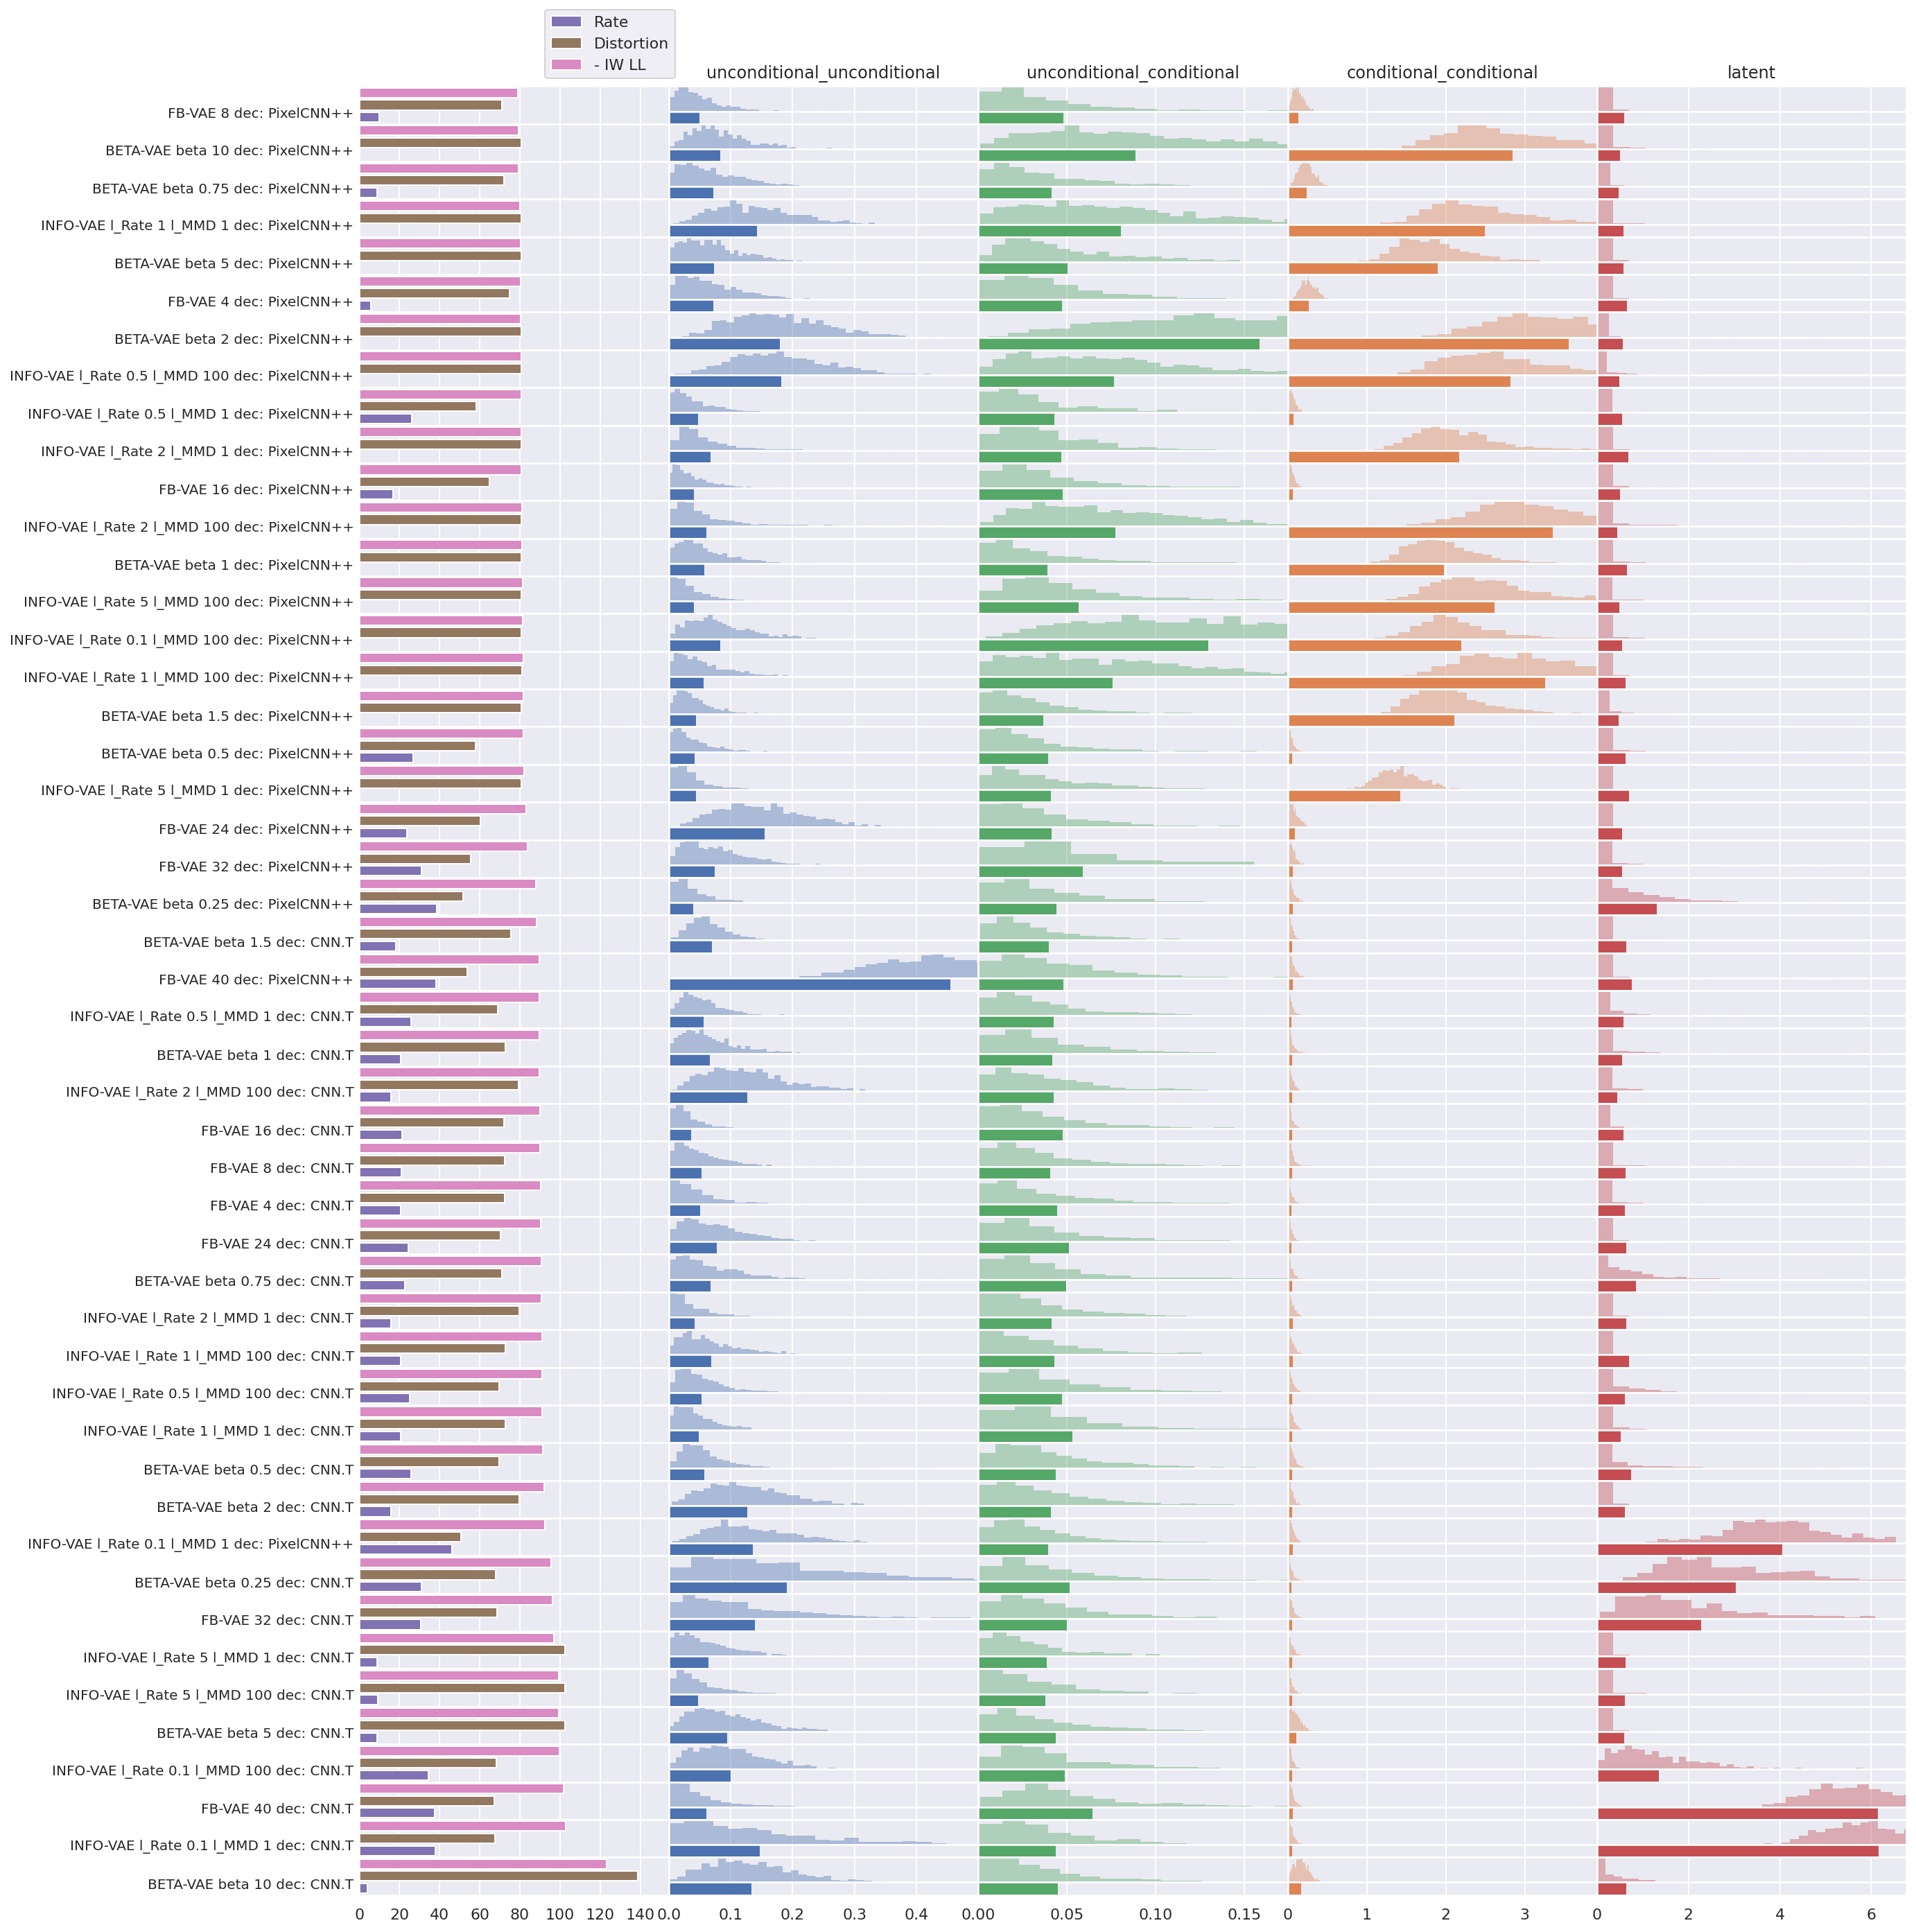

In [29]:
import itertools

palette = itertools.cycle(sns.color_palette())

test_kl = all_kls["mnist"]
test_kl["latent"] = kl_image_latents

# this may be some other order as well
# group_names = test_kl["unconditional_unconditional"]["kl_avg"].index.values

global_stats_df = global_stats_df.sort_values("IW LL")
group_names = global_stats_df[global_stats_df.image_or_language == "image"].index.values[::-1]
group_names = [g for g in group_names if g in test_kl["unconditional_unconditional"]["kl_avg"].index.values]

max_nll = - global_stats_df[global_stats_df.image_or_language == "image"]["IW LL"].min()
min_nll = - global_stats_df[global_stats_df.image_or_language == "image"]["IW LL"].max()

print(min_nll, max_nll)

print(len(group_names))

c_dict = dict()

for k in ["unconditional_unconditional", "conditional_conditional", "unconditional_conditional", "latent", "rate", "distortion", "nll"]:
    c_dict[k] = next(palette)


ncols = 5
nrows = len(group_names)
row_h = 0.5
col_w = 4

# c_dict = {"unconditional_unconditional": "#2A26F5",
#           "conditional_conditional": "#E458B3",
#           "unconditional_conditional": "#EF8C7D",
#           "latent": "blue"}

height_ratios = []
for _ in range(nrows):
    height_ratios.extend([2, 1])
    
fig = plt.figure(figsize=(col_w*ncols, row_h*nrows)) #constrained_layout=True, 
gs = GridSpec(ncols=ncols, 
              nrows=nrows*2, 
              figure=fig, 
              height_ratios=height_ratios,
              wspace=0.0, 
              hspace=0.0) #

MAX_GROUPS = 100

# Plot the intrinsic evaluation statistics
group_n = 0
for group_name in group_names:
    if group_name == "data_group": continue
        
    
    row = group_n * 2
    ax = fig.add_subplot(gs[row:row+2, 0])
    ax.set_xlim([0, max_nll*1.1])
    
    if row == 0:
        legend_elements = [matplotlib.patches.Patch(facecolor=c_dict["rate"], edgecolor='w', label='Rate'),
                           matplotlib.patches.Patch(facecolor=c_dict["distortion"], edgecolor='w', label='Distortion'),
                           matplotlib.patches.Patch(facecolor=c_dict["nll"], edgecolor='w', label='- IW LL')]


        ax.legend(handles=legend_elements, loc=(0.6, 1.2))
    
    ax.set_ylabel(group_name, rotation="horizontal", ha='right', size=10, y=0.1)
    
    # Get R, D, LL values for group
    select = global_stats_df[global_stats_df.index == group_name]
    nll, r, d = - select["IW LL"].values[0], select["kl_prior_post"].values[0], select["distortion"].values[0]
    
    # Grouped bar
    widths = [r, d, nll]
    ax.barh(["Rate", "Distortion", "NLL"], width=widths, color=[c_dict["rate"], c_dict["distortion"], c_dict["nll"]])
    
    group_n += 1
    
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    if group_n != len(group_names):
        ax.set_xticklabels([])
    else:
        print()
        
    ax.xaxis.set_major_locator(MaxNLocator(prune='upper'))
        
    if group_n == MAX_GROUPS: break

# Plot the KLs
for stat_i, (stat_name, kls) in enumerate(test_kl.items()):
    
    col = stat_i + 1
    
    kl_avg = kls["kl_avg"]
    kl_dists = kls["kl_dists"]
    
    max_avg_kl = kl_avg.max()["Avg. KL comp"]
    group_n = 0
    
    for group_name in group_names:
        
        # if group_name == "data_group" or group_name not in kl_dists: continue
            
        row = group_n * 2
        
        dist = kl_dists[group_name]
        avg = kl_avg.iloc[kl_avg.index == group_name]["Avg. KL comp"].values[0]
        
        print(group_n, group_name, f"avg. KL = {avg:.2f} \t\t\t\t", end="\r")
        
        dist_ax = fig.add_subplot(gs[row, col])
        avg_ax = fig.add_subplot(gs[row+1, col])
        
        if row == 0:
            dist_ax.set_title(stat_name)
        
        dist_ax.hist(dist, bins=40, density=True, color=c_dict[stat_name], alpha=0.4, lw=0)
        avg_ax.barh([group_name], [avg], color=c_dict[stat_name], lw=0)
        
        dist_ax.set_xlim([0, max_avg_kl*1.1])
        avg_ax.set_xlim([0, max_avg_kl*1.1])
        
        dist_ax.set_yticks([])
        avg_ax.set_yticks([])
        
        dist_ax.set_yticklabels([])
        avg_ax.set_yticklabels([])
        
        #ax1.barh([''], [avgs[i]], left=[cum_avgs[i]], color=c_dict[stats[i]], lw=0, height=0.1)
        
        group_n += 1
        
        dist_ax.set_xticklabels([])
        if group_n != len(group_names):
            avg_ax.set_xticklabels([])
        
        if group_n == MAX_GROUPS: break
            

    

In [ ]:
all_df, kl_comp_dists = compute_all_divergences_data_model_groups(dp_mixtures, 
                                                                  surprisal_values, 
                                                                  num_components=NUM_COMPS)

all_keys_present = True
for k in ["unconditional_unconditional", "unconditional_conditional", "conditional_conditional"]:
    if k not in kl_comp_dists:
        all_keys_present = False
print("all_keys_present", all_keys_present)

if all_keys_present:
    torch.save({"kl_comp_dists":kl_comp_dists, "divergence_df": all_df}, SAVE_DP_COMP_KL_DISTS_FILE)

In [ ]:
SORT_ON = "kl_comp sum"

all_df = all_df[all_df.index != "data_group"]
all_df_select = all_df[(run_df.beta_beta < 2) & (run_df.l_mmd < 100)]
plot_divergences_data_model_groups(all_df_select, sort_on=SORT_ON, plot_only=None)

In [ ]:
# plot_divergences_data_model_groups(all_df_select, sort_on=SORT_ON, plot_only="kl_comp", figsize=(6, 12))
# plot_divergences_data_model_groups(all_df, sort_on=SORT_ON, plot_only="kl_comp", figsize=(6, 12))
plot_divergences_data_model_groups(all_df[all_df["kl_comp sum"] < 1.0], sort_on=SORT_ON, plot_only="kl_comp", figsize=(6, 12))

In [ ]:
global_stats_df_select["-IW LL"] = - global_stats_df_select["IW LL"]

plot_divergences_data_model_groups_against_other_stat(all_df_select, global_stats_df_select, 
                                                      plot_against="-IW LL", plot_against_name="-IW LL", 
                                                      stat="kl_comp", figsize=(14, 18))

plot_divergences_data_model_groups_against_other_stat(all_df_select, global_stats_df_select, 
                                                      plot_against="kl_prior_post", plot_against_name="Rate", 
                                                      stat="kl_comp", figsize=(14, 18))

plot_divergences_data_model_groups_against_other_stat(all_df_select, global_stats_df_select, 
                                                      plot_against="distortion", plot_against_name="Distortion", 
                                                      stat="kl_comp", figsize=(14, 18))



# OLD PLOT CODE BELOW

In [3]:
# SAVE_DIR = "output_files"

# files = [f"{SAVE_DIR}/topic_model_dp_mixtures_kl_comp_dists.pt", f"{SAVE_DIR}/MNIST_dp_mixtures_kl_comp_dists.pt"]

# d = torch.load(files[1])
# d.keys()

In [4]:
# all_df, kl_comp_dists = d["divergence_df"], d["kl_comp_dists"]

In [5]:
# from matplotlib.ticker import MaxNLocator
# from matplotlib.gridspec import GridSpec

# # plt.rcParams['axes.grid'] = False
# # plt.rcParams['axes.facecolor'] = "white"

# N_groups = len(list(kl_comp_dists.values())[0])

# c_dict = {"unconditional_unconditional": "#2A26F5",
#           "conditional_conditional": "#E458B3",
#           "unconditional_conditional": "#EF8C7D"}

# max_groups = N_groups - 1 # -1 for data_group

# height_ratios = []
# for _ in range(max_groups):
#     height_ratios.extend([1, 1])
    
# fig = plt.figure(figsize=(8*2, 1.0*max_groups)) #constrained_layout=True, 
# gs = GridSpec(ncols=2, 
#               nrows=max_groups*2, 
#               figure=fig, 
#               height_ratios=height_ratios, 
#               wspace=0.0, 
#               hspace=0.0)
# # fig, axs = plt.subplots(ncols=2, nrows=max_groups*2, figsize=(5*2, 0.5*max_groups), sharex="col", 
# #                         gridspec_kw={"height_ratios":height_ratios})


# stats = ["unconditional_unconditional", "conditional_conditional", "unconditional_conditional"]
# group_names = all_df.sort_values("kl_comp sum").index.values

# max_xlim = 5.0

# col = 1
# group_n = 0

# for i, group_name in enumerate(group_names):
#     print(f"{i:3d}/{len(group_names)}", end="\r")
    
#     #print(group_n, group_name)

#     if group_name == "data_group":
#         continue
        
#     avg_prev = 0.0
#     cum_avgs = [0.0]
#     avgs = []
    
#     row = group_n * 2
    
#     ax = fig.add_subplot(gs[row, col])
#     ax1 = fig.add_subplot(gs[row+1, col])
    
#     for stat in stats:
        
#         kl_comp_vals = kl_comp_dists[stat][group_name]
        
#         ax.hist(np.array(kl_comp_vals)+avg_prev, bins=60, density=True, lw=0, 
#                       color=c_dict[stat], alpha=0.4)
        
#         avg = np.mean(kl_comp_vals)
#         avgs.append(avg)
#         avg_prev += avg
#         cum_avgs.append(avg_prev)
        
#         ax.axvline(avg_prev, color=c_dict[stat], linestyle='--', lw=0.1)
#         ax.set_yticks([])
#         ax.set_xlim([0.0, max_xlim])
    
#     for i in range(3):
#         ax1.barh([''], [avgs[i]], left=[cum_avgs[i]], color=c_dict[stats[i]], lw=0, height=0.1)
    
#     ax.set_ylabel(group_name, rotation="horizontal", ha='right', size=10, y=0.1)
#     ax1.set_xlim([0.0, max_xlim])

#     ax.set_xticklabels([])
#     if (group_n + 1) != (len(group_names) - 1):
#         ax1.set_xticklabels([])
    
#     group_n += 1
    
# print()

# col = 0
# group_n = 0
# for i, group_name in enumerate(group_names):
#     print(f"{i:3d}/{len(group_names)}", end='\r')
    
#     if group_name == "data_group":
#         continue
    
#     row = group_n * 2
#     ax = fig.add_subplot(gs[row+1:row+2, col])
    
#     # Get R, D, LL values for group
#     select = global_stats_df[global_stats_df.index == group_name]
#     nll, r, d = - select["IW LL"].values[0], select["kl_prior_post"].values[0], select["distortion"].values[0]
    
#     # Grouped bar
#     widths = [r, d, nll]
#     ax.barh(["Rate", "Distortion", "NLL"], width=widths, color=['red', 'grey', 'black'])
    
#     # Ticks and lims
#     ax.set_yticks([])
#     ax.set_xlim(180, 0)
#     if (group_n + 1) != (len(group_names) - 1):
#         ax.set_xticklabels([])
#     else:
#         ax.xaxis.set_major_locator(MaxNLocator(prune='lower'))
    
#     group_n += 1

# plt.subplots_adjust(wspace=0.0, hspace=0)